In [1]:
import pandas as pd
import re
from utils import get_data

# Exploration

In [3]:
df = get_data()
for i in df["Lang"].unique():
    df[df["Lang"] == i].to_csv(f"data/{i}.csv", index=False)

In [4]:
lang = df["Lang"].unique()
lang

array(['GER', 'TUR', 'CHI', 'TEL', 'ARA', 'SPA', 'HIN', 'JPN', 'KOR',
       'FRE', 'ITA'], dtype=object)

In [5]:
lang = df["Lang"].unique()
res = {}
for l in lang:
    res[l] = {}

for i in df["Lang"].unique():
    res[i]["nb"] = df[df["Lang"] == i]["Lang"].count()
    res[i]["moy length"] = df[df["Lang"] == i]["Text"].str.len().mean()
    res[i]["max length"] = df[df["Lang"] == i]["Text"].str.len().max()
    res[i]["min length"] = df[df["Lang"] == i]["Text"].str.len().min()
    res[i]["esperance length"] = df[df["Lang"] == i]["Text"].str.len().std()
    res[i]["moy nb mot"] = df[df["Lang"] == i]["Text"].str.split().str.len().mean()
    res[i]["max nb mot"] = df[df["Lang"] == i]["Text"].str.split().str.len().max()
    res[i]["min nb mot"] = df[df["Lang"] == i]["Text"].str.split().str.len().min()
    res[i]["esperance nb mot"] = df[df["Lang"] == i]["Text"].str.split().str.len().std()
    res[i]["moy nb phrase"] = df[df["Lang"] == i]["Text"].str.split(".").str.len().mean()
    res[i]["max nb phrase"] = df[df["Lang"] == i]["Text"].str.split(".").str.len().max()
    res[i]["min nb phrase"] = df[df["Lang"] == i]["Text"].str.split(".").str.len().min()
    res[i]["esperance nb phrase"] = df[df["Lang"] == i]["Text"].str.split(".").str.len().std()
    

    print(  
        "lang =", i, ", nb=", round(df[df["Lang"] == i]["Lang"].count(), 3), 
        ", moy length=", round(df[df["Lang"] == i]["Text"].str.len().mean(), 3), 
        ", max length=", round(df[df["Lang"] == i]["Text"].str.len().max(), 3),
        ", min length=", round(df[df["Lang"] == i]["Text"].str.len().min(), 3),
        ", esperance length=", round(df[df["Lang"] == i]["Text"].str.len().std(), 3),
        ", moy nb mot :", round(df[df["Lang"] == i]["Text"].str.split().str.len().mean(), 3),
        ", max nb mot:", round(df[df["Lang"] == i]["Text"].str.split().str.len().max(), 3),
        ", min nb mot:", round(df[df["Lang"] == i]["Text"].str.split().str.len().min(), 3),
        ", esperance nb mot:", round(df[df["Lang"] == i]["Text"].str.split().str.len().std(), 3),
        ", moy nb phrase:", round(df[df["Lang"] == i]["Text"].str.split(".").str.len().mean(), 3),
        ", max nb phrase:", round(df[df["Lang"] == i]["Text"].str.split(".").str.len().max(), 3),
        ", min nb phrase:", round(df[df["Lang"] == i]["Text"].str.split(".").str.len().min(), 3),
        ", esperance nb phrase:", round(df[df["Lang"] == i]["Text"].str.split(".").str.len().std(), 3),
    )


lang = GER , nb= 900 , moy length= 1953.983 , max length= 4142 , min length= 334 , esperance length= 367.666 , moy nb mot : 376.533 , max nb mot: 806 , min nb mot: 63 , esperance nb mot: 69.772 , moy nb phrase: 18.434 , max nb phrase: 40 , min nb phrase: 5 , esperance nb phrase: 4.336
lang = TUR , nb= 900 , moy length= 1842.998 , max length= 4155 , min length= 69 , esperance length= 437.412 , moy nb mot : 352.671 , max nb mot: 776 , min nb mot: 15 , esperance nb mot: 83.303 , moy nb phrase: 18.611 , max nb phrase: 44 , min nb phrase: 1 , esperance nb phrase: 5.567
lang = CHI , nb= 900 , moy length= 1853.389 , max length= 4621 , min length= 92 , esperance length= 432.715 , moy nb mot : 361.812 , max nb mot: 876 , min nb mot: 16 , esperance nb mot: 82.095 , moy nb phrase: 18.448 , max nb phrase: 38 , min nb phrase: 2 , esperance nb phrase: 5.329
lang = TEL , nb= 900 , moy length= 1901.13 , max length= 4074 , min length= 748 , esperance length= 386.245 , moy nb mot : 359.039 , max nb mot:

In [6]:
df["length"] = df["Text"].str.len()
df["mot"] = df["Text"].str.split().str.len()
df["phrase"] = df["Text"].str.split(".").str.len()

# Machine learning

## Implémentations

### imports

In [43]:
# modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np
import plotly.express as px

### Metrics

In [103]:
def draw_confusion_matrix(y_test, y_pred, labels):
    labels_inverse = {labels[lang]:lang for lang in labels}
    y_pred = [labels_inverse[i] for i in y_pred]
    y_test = [labels_inverse[i] for i in y_test]
    lang_list =  [ k for k, v in labels.items()]
    data = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=lang_list)
    fig = px.imshow(data,
                    labels=dict(x="Languages Réel", y="Languages Prédit", color="confusion"),
                    x=lang_list,
                    y=lang_list,
                    text_auto=True,
                    aspect="auto")
    fig.update_xaxes(side="top")
    fig.show()

def display_results(y_true, y_pred, labels, draw=False):
    
    average_param = "macro"
    if draw:
        draw_confusion_matrix(y_true, y_pred, labels)
    
    print("Accuracy ", accuracy_score(y_true, y_pred))
    
    print("Precision -", average_param)
    print("precision score ", precision_score(y_true, y_pred, average=average_param, zero_division=1))

    print("Recall -", average_param)
    print("recall score ",   recall_score(y_true, y_pred, average=average_param, zero_division=1))
    
    print("F1 -", average_param)
    print("f1 score ", f1_score(y_true, y_pred, average=average_param, zero_division=1))
    return

### Label encoder

In [9]:
def get_label_encoder(y):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(y)
    labels = {}

    for a in y.unique():
        labels[a] = label_encoder.transform([a])[0]
    return label_encoder, labels

### Split data

In [10]:
def get_train_dev_test(X, y):
    X_train, X_mid, y_train, y_mid = train_test_split(X, y, test_size=0.2, random_state=42)

    X_dev, X_test, y_dev, y_test = train_test_split(X_mid, y_mid, test_size=0.5, random_state=42)

    return X_train, X_dev, X_test, y_train, y_dev, y_test

### Generic Function to test a model and vectorizer

In [11]:
def train_one_model(vectorizer, model, labels, label_encoder, X_train, y_train, X_dev, y_dev, X_test, y_test):

    X_train_vect = vectorizer.fit_transform(X_train)
    X_dev_vect = vectorizer.transform(X_dev)
    X_test_vect = vectorizer.transform(X_test)

    y_train_labels = label_encoder.transform(y_train)
    y_dev_labels = label_encoder.transform(y_dev)
    y_test_labels = label_encoder.transform(y_test)
    scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train_vect)
    X_scaled_train = scaler.transform(X_train_vect)

    model.fit(X_scaled_train, y_train_labels)

    X_dev_scaled = scaler.transform(X_dev_vect)
    y_pred_dev = model.predict(X_dev_scaled)
    accuracy_dev = accuracy_score(y_dev_labels, y_pred_dev)
    print(f"Accuracy DEV {vectorizer} et {model}: {accuracy_dev:.3f}")
    display_results(y_dev_labels, y_pred_dev, labels)
    
    X_test_scaled = scaler.transform(X_test_vect)
    y_pred_test = model.predict(X_test_scaled)

    # Calcul de l'accuracy sur les données de test
    accuracy_test = accuracy_score(y_test_labels, y_pred_test)
    print(f"Accuracy TEST {vectorizer} et {model}: {accuracy_test:.3f}")
    display_results(y_test_labels, y_pred_test, labels)

## Logistic Regression on the whole dataset

In [38]:

df = get_data()
X = df["Text"]
y = df["Lang"]

X_train, X_dev, X_test, y_train, y_dev, y_test = get_train_dev_test(X, y)
label_encoder, labels = get_label_encoder(df["Lang"])

train_one_model(CountVectorizer(), SGDClassifier(), labels, label_encoder, X_train, y_train, X_dev, y_dev, X_test, y_test)

Accuracy DEV CountVectorizer() et SGDClassifier(): 0.509


Accuracy  0.509090909090909
Precision - macro
precision score  0.5109613862019583
Recall - macro
recall score  0.5117422169058279
F1 - macro
f1 score  0.5077686078214771
Accuracy TEST CountVectorizer() et SGDClassifier(): 0.507


Accuracy  0.5070707070707071
Precision - macro
precision score  0.506527142532359
Recall - macro
recall score  0.5074075761088959
F1 - macro
f1 score  0.5056669808260096


## Logistic Regression on CHI KOR JAP

In [99]:
df_chi = pd.read_csv("data/CHI.csv")
df_kor = pd.read_csv("data/KOR.csv")
df_jap = pd.read_csv("data/JPN.csv")

df_concat = pd.concat([df_chi, df_kor, df_jap])
X = df_concat["Text"]
y = df_concat["Lang"]

X_train, X_dev, X_test, y_train, y_dev, y_test = get_train_dev_test(X, y)
label_encoder, labels = get_label_encoder(df_concat["Lang"])
train_one_model(TfidfVectorizer(), LogisticRegression(), labels, label_encoder, X_train, y_train, X_dev, y_dev, X_test, y_test)

Accuracy DEV TfidfVectorizer() et LogisticRegression(): 0.759


Accuracy  0.7592592592592593
Precision - macro
precision score  0.7619361023542207
Recall - macro
recall score  0.7611108309472713
F1 - macro
f1 score  0.7568543277335014
Accuracy TEST TfidfVectorizer() et LogisticRegression(): 0.741


Accuracy  0.7407407407407407
Precision - macro
precision score  0.7436962413102391
Recall - macro
recall score  0.7411349667610053
F1 - macro
f1 score  0.7415286090149479


## Pipeline

In [102]:
def process_pipeline(pipeline, df, draw=False):
    label_encoder, labels = get_label_encoder(df["Lang"])

    X = df["Text"]
    y = df["Lang"]
    X_train, X_dev, X_test, y_train, y_dev, y_test = get_train_dev_test(X, y)

    y_train_labels = label_encoder.transform(y_train)
    y_dev_labels = label_encoder.transform(y_dev)

    pipeline.fit(X_train, y_train_labels)

    y_pred_dev = pipeline.predict(X_dev)
    display_results(y_dev_labels, y_pred_dev, labels, draw)

In [104]:
# LinearSVC(dual="auto", random_state=0, tol=1e-5)
clf = make_pipeline(
    TfidfVectorizer(), 
    # StandardScaler(with_mean=False),
    #LinearSVC(dual="auto", random_state=0, tol=1e-5),
    #KNeighborsClassifier(n_neighbors=3)
    # LogisticRegression()
    # DecisionTreeClassifier()
    # RandomForestClassifier()
    SGDClassifier()
)

df_chi = pd.read_csv("data/CHI.csv")
df_chi = df_chi.sample(300)
df_kor = pd.read_csv("data/KOR.csv")
df_kor = df_kor.sample(300)
df_jap = pd.read_csv("data/JPN.csv")
df_jap = df_jap.sample(300)
df_asie = pd.concat([df_chi, df_kor, df_jap])
df_asie["Lang"] = "ASI"

df_hin = pd.read_csv("data/HIN.csv")
df_hin = df_hin.sample(450)
df_tel = pd.read_csv("data/TEL.csv")
df_tel = df_tel.sample(450)
df_indian = pd.concat([df_hin, df_tel])
df_indian["Lang"] = "IND"


df_other = get_data(exclude=["HIN", "TEL", "CHI", "JPN", "KOR"])
df_concat = pd.concat([df_other, df_asie, df_indian])
process_pipeline(clf, df_concat)

Accuracy  0.7708333333333334
Precision - macro
precision score  0.7669264183767259
Recall - macro
recall score  0.7676281875598532
F1 - macro
f1 score  0.7642942006067908


In [82]:
def process_one_vs_all(Lang, clf):
    df_other = get_data(exclude=[Lang])
    df_other["Lang"] = "OTH"
    df_other = df_other.sample(900)
    df_spa = get_data(include=[Lang])

    df_concat = pd.concat([df_other, df_spa])
    process_pipeline(clf, df_concat)

In [96]:
clf = make_pipeline(
    CountVectorizer(), 
    # StandardScaler(with_mean=False),
    # LinearSVC(dual="auto", random_state=0, tol=1e-5),
    # KNeighborsClassifier(n_neighbors=3)
    # LogisticRegression()
    # DecisionTreeClassifier()
    # RandomForestClassifier()
    SGDClassifier()
)

for lang in df["Lang"].unique():
    process_one_vs_all(lang, clf)

Accuracy  0.8222222222222222
Precision - macro
precision score  0.8229102167182663
Recall - macro
recall score  0.8219533275713051
F1 - macro
f1 score  0.8220244716351501


Accuracy  0.8055555555555556
Precision - macro
precision score  0.8065476190476191
Recall - macro
recall score  0.8052228670206198
F1 - macro
f1 score  0.8052610429353034


Accuracy  0.8111111111111111
Precision - macro
precision score  0.8116425658138673
Recall - macro
recall score  0.8113347326830473
F1 - macro
f1 score  0.8110877886158785


Accuracy  0.8333333333333334
Precision - macro
precision score  0.8340557275541796
Recall - macro
recall score  0.8330658105939004
F1 - macro
f1 score  0.8331479421579533


Accuracy  0.7944444444444444
Precision - macro
precision score  0.7947798119742702
Recall - macro
recall score  0.7942338560316089
F1 - macro
f1 score  0.7942857142857143


Accuracy  0.7555555555555555
Precision - macro
precision score  0.7638095238095238
Recall - macro
recall score  0.7565131497715767
F1 - macro
f1 score  0.7540678176624023


Accuracy  0.8277777777777777
Precision - macro
precision score  0.8296130952380952
Recall - macro
recall score  0.8281886652673169
F1 - macro
f1 score  0.8276447876447877


Accuracy  0.8277777777777777
Precision - macro
precision score  0.8288690476190477
Recall - macro
recall score  0.8274478330658106
F1 - macro
f1 score  0.8275169237426974


Accuracy  0.8555555555555555
Precision - macro
precision score  0.8556611927398444
Recall - macro
recall score  0.8556611927398444
F1 - macro
f1 score  0.8555555555555555


Accuracy  0.8611111111111112
Precision - macro
precision score  0.8620732310737259
Recall - macro
recall score  0.8614026423015186
F1 - macro
f1 score  0.8610725201444845


Accuracy  0.8722222222222222
Precision - macro
precision score  0.8722222222222222
Recall - macro
recall score  0.8722681812569453
F1 - macro
f1 score  0.8722182783419241


# Cross Validation

## Shuffle

In [21]:
for i in df["Lang"].unique():
    df_ara = pd.read_csv(f"data/{i}.csv")
    df_ara.sample(frac=1).reset_index(drop=True).to_csv(f"data/{i}.csv", index=False)

In [22]:
import pandas as pd
import glob
import random

files = glob.glob("data/*.csv")

# Read lines from each file
lines_from_each_file = []
for file_path in files:
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        lines_from_each_file.append(lines)

# Alternate lines from each file with random order in each cycle
combined_lines = []
num_lines = len(lines_from_each_file[0])
for i in range(num_lines):
    # Shuffle the order of files for each line
    random.shuffle(lines_from_each_file)

    # Add one line from each file in the shuffled order
    for lines in lines_from_each_file:
        combined_lines.append(lines[i])

# Create DataFrame
df = pd.DataFrame([line.split(r',"') for line in combined_lines])
df.drop(columns=[2], inplace=True)
df.head(15)


,0,1
0,FRE,"It might be confusing at first , or might be ..."
1,GER,IThe importance and popularity of travelling ...
2,CHI,I agree this statement . Young people are too...
3,SPA,i am desagree with the sentence that the best...
4,ITA,In the last years this topic became very actu...
5,TEL,"In twenty years from now , there is a high po..."
6,KOR,"Nowadays , it is said that youngsters are not..."
7,ARA,It is known that as human beings we are set a...
8,GER,In my opinion it is in general better when yo...
9,JPN,Young people enjoy life more than older peopl...


In [23]:
tel = pd.read_csv("data/TEL.csv")
hin = pd.read_csv("data/HIN.csv")
chi = pd.read_csv("data/CHI.csv")
fre = pd.read_csv("data/FRE.csv")
ita = pd.read_csv("data/ITA.csv")

tel_hin = pd.concat([tel, hin])
tel_hin

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(tel_hin["Text"])
y = tel_hin["Lang"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_scaled = scaler.transform(X_train)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_scaled, y_train.values.ravel())

# Make predictions on the test set
# scaler = preprocessing.StandardScaler(with_mean=False).fit(X_test)
y_pred = model.predict(scaler.transform(X_test))

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7


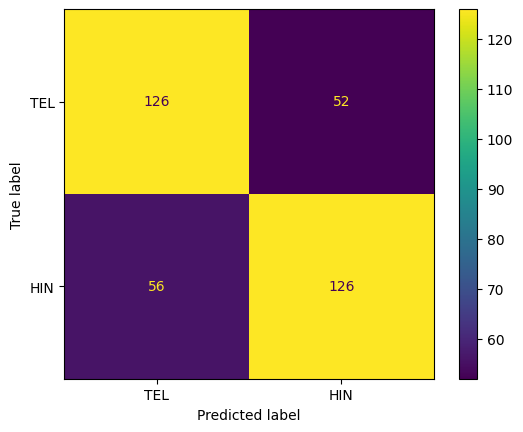

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred, y_test, labels=tel_hin["Lang"].unique()), display_labels=tel_hin["Lang"].unique()).plot()

# SVM

In [28]:
from sklearn.svm import SVC

# Vectorize the text and combine with other numerical features
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df['Text'])
X_other_numerical = df[["mot", "length", "phrase"]].values
X_all = hstack((X_text, X_other_numerical))

X_train, X_test, y_train, y_test = train_test_split(X_text, df[["Lang"]], test_size=0.4, random_state=42)

scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

# Create and train the SVM model
svm_model = SVC()
svm_model.fit(X_scaled_train, y_train.values.ravel())

# Make predictions on the test set
y_pred = svm_model.predict(X_scaled_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
